<a href="https://colab.research.google.com/github/Nour-Selmi/Fraud-Detection-System/blob/main/projetDetectionFraudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from datetime import datetime

# Bibliothèques pour le Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, ConfusionMatrixDisplay)

# Algorithmes de classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# XGBoost
import xgboost as xgb

# Pour gérer le déséquilibre des classes
from imblearn.over_sampling import SMOTE

# Configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("="*80)
print(" SYSTÈME DE DÉTECTION DE FRAUDE - DÉMARRAGE")
print("="*80)
print(" Toutes les bibliothèques importées avec succès!\n")

 SYSTÈME DE DÉTECTION DE FRAUDE - DÉMARRAGE
 Toutes les bibliothèques importées avec succès!



In [2]:
# SECTION 2: CHARGEMENT DES DONNÉES
df = pd.read_csv('/content/drive/MyDrive/DetectionFraude.csv')
print(f"\n Dataset chargé avec succès!")
print(f" Dimensions: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print("\n" + "="*80)
print("APERÇU DES DONNÉES")
print("="*80)
df.head()


 Dataset chargé avec succès!
 Dimensions: 6,362,620 lignes × 11 colonnes

APERÇU DES DONNÉES


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# SECTION 3: EXPLORATION DES DONNÉES
print("\n" + "="*80)
print("INFORMATIONS SUR LE DATASET")
print("="*80)
df.info()
print("\n" + "="*80)
print("STATISTIQUES DESCRIPTIVES")
print("="*80)
df.describe()
print("\n" + "="*80)
print("VALEURS MANQUANTES")
print("="*80)
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print(" Aucune valeur manquante!")
else:
    print(missing_values[missing_values > 0])
print(f"\n Nombre de lignes dupliquées: {df.duplicated().sum()}")
print("\n" + "="*80)
print("DISTRIBUTION DE LA VARIABLE CIBLE: isFraud")
print("="*80)
print(df['isFraud'].value_counts())
print("\nPourcentages:")
print(df['isFraud'].value_counts(normalize=True) * 100)


INFORMATIONS SUR LE DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB

STATISTIQUES DESCRIPTIVES

VALEURS MANQUANTES
 Aucune valeur manquante!

 Nombre de lignes dupliquées: 0

DISTRIBUTION DE LA VARIABLE CIBLE: isFraud
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Pourcentages:
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


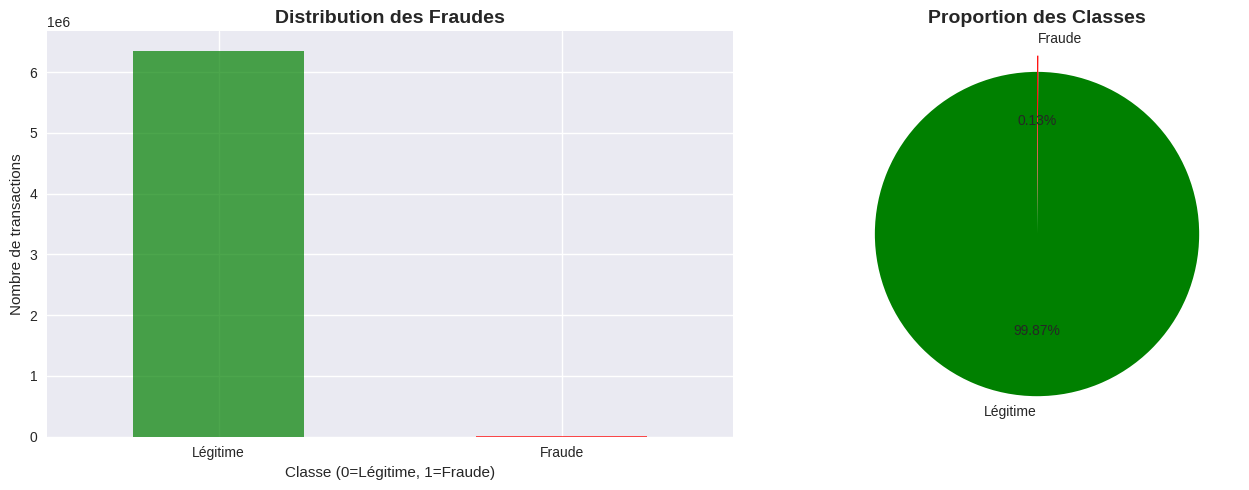


DISTRIBUTION DES TYPES DE TRANSACTIONS
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


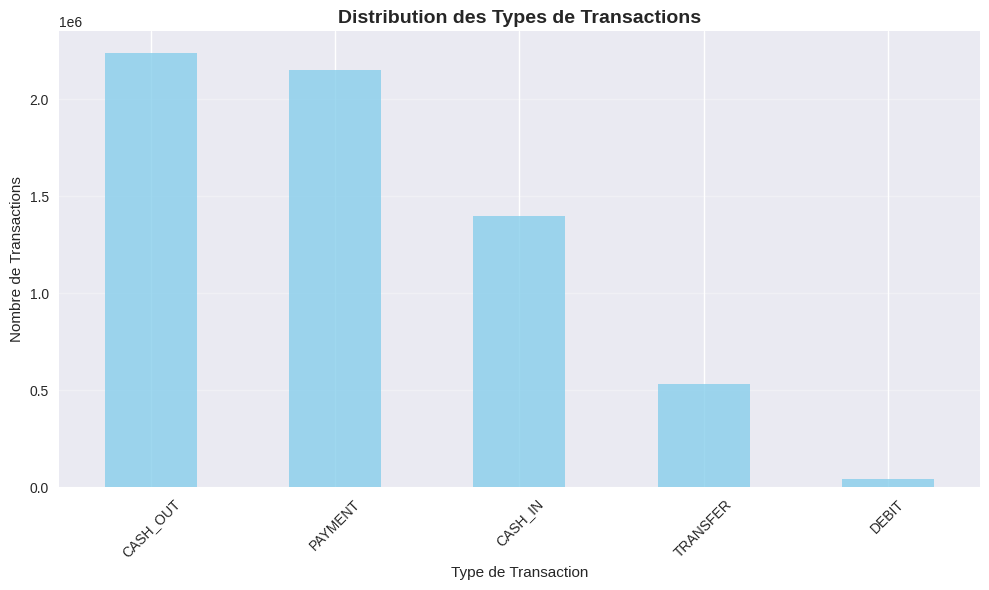

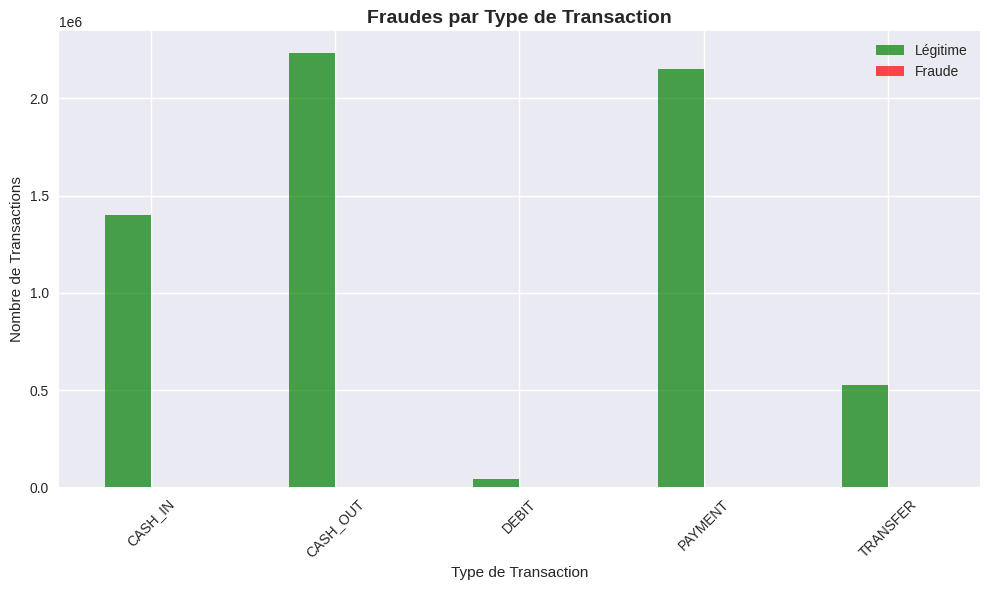

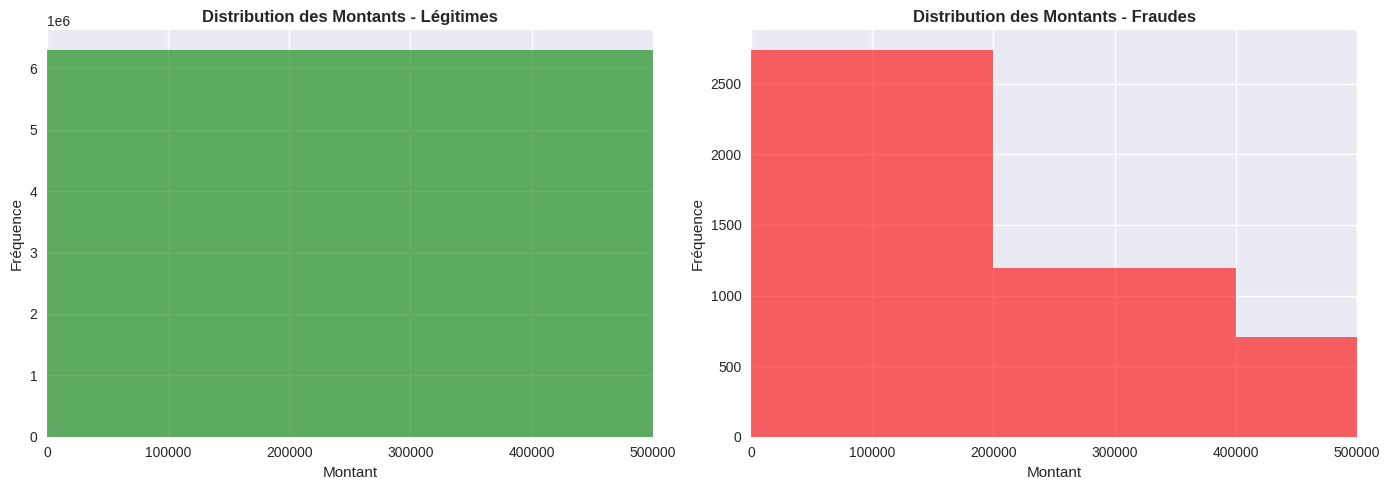

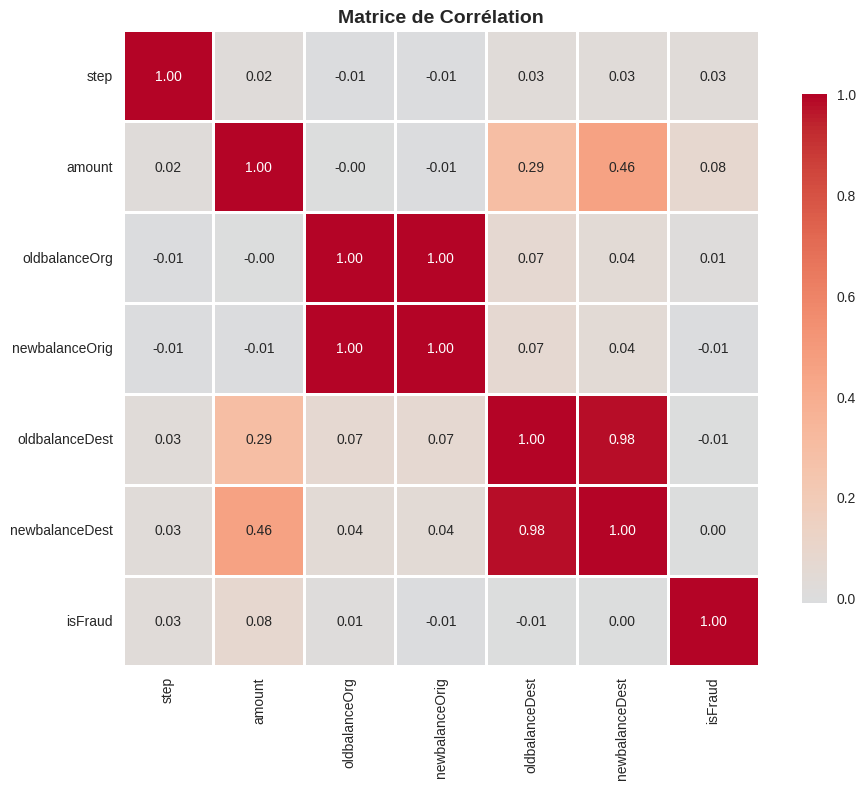


Corrélations avec isFraud:
isFraud           1.000000
amount            0.076688
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64


In [4]:
# SECTION 4: VISUALISATION DES DONNÉES
# ============================================

# 4.1 Distribution de la variable cible
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Count plot
df['isFraud'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'], alpha=0.7)
axes[0].set_title('Distribution des Fraudes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Classe (0=Légitime, 1=Fraude)')
axes[0].set_ylabel('Nombre de transactions')
axes[0].set_xticklabels(['Légitime', 'Fraude'], rotation=0)

# Graphique 2: Pie chart
df['isFraud'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%',
                                   labels=['Légitime', 'Fraude'], colors=['green', 'red'],
                                   explode=[0, 0.1], startangle=90)
axes[1].set_title('Proportion des Classes', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# 4.2 Distribution des types de transactions
print("\n" + "="*80)
print("DISTRIBUTION DES TYPES DE TRANSACTIONS")
print("="*80)
print(df['type'].value_counts())

plt.figure(figsize=(10, 6))
df['type'].value_counts().plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Distribution des Types de Transactions', fontsize=14, fontweight='bold')
plt.xlabel('Type de Transaction')
plt.ylabel('Nombre de Transactions')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4.3 Fraudes par type de transaction
fraud_by_type = pd.crosstab(df['type'], df['isFraud'])
fraud_by_type.plot(kind='bar', figsize=(10, 6), color=['green', 'red'], alpha=0.7)
plt.title('Fraudes par Type de Transaction', fontsize=14, fontweight='bold')
plt.xlabel('Type de Transaction')
plt.ylabel('Nombre de Transactions')
plt.legend(['Légitime', 'Fraude'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.4 Distribution des montants
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Transactions légitimes
df[df['isFraud']==0]['amount'].hist(bins=50, ax=axes[0], color='green', alpha=0.6)
axes[0].set_title('Distribution des Montants - Légitimes', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Montant')
axes[0].set_ylabel('Fréquence')
axes[0].set_xlim(0, 500000)

# Transactions frauduleuses
df[df['isFraud']==1]['amount'].hist(bins=50, ax=axes[1], color='red', alpha=0.6)
axes[1].set_title('Distribution des Montants - Fraudes', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Montant')
axes[1].set_ylabel('Fréquence')
axes[1].set_xlim(0, 500000)

plt.tight_layout()
plt.show()

# 4.5 Matrice de corrélation
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                'oldbalanceDest', 'newbalanceDest', 'isFraud']

plt.figure(figsize=(10, 8))
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrélations avec isFraud:")
print(correlation['isFraud'].sort_values(ascending=False))

In [5]:
# SECTION 5: PRÉTRAITEMENT DES DONNÉES
# ============================================
print("\n" + "="*80)
print("PRÉTRAITEMENT DES DONNÉES")
print("="*80)

# 5.1 Créer une copie pour le prétraitement
df_processed = df.copy()
print(" Copie du dataset créée pour prétraitement")

# 5.2 Feature Engineering (SANS DATA LEAKAGE)
print("\n Création de nouvelles features (sans data leakage)...")

# Features basées UNIQUEMENT sur info disponible AVANT la transaction
df_processed['amount_to_balance_ratio'] = df_processed['amount'] / (df_processed['oldbalanceOrg'] + 1)
df_processed['dest_balance_ratio'] = df_processed['amount'] / (df_processed['oldbalanceDest'] + 1)

# Flag pour montants suspects
df_processed['high_amount'] = (df_processed['amount'] > df_processed['amount'].quantile(0.95)).astype(int)
df_processed['round_amount'] = (df_processed['amount'] % 1000 == 0).astype(int)

# Flag pour soldes nuls AVANT transaction (comportement suspect)
df_processed['zero_balance_orig'] = (df_processed['oldbalanceOrg'] == 0).astype(int)

print(" Nouvelles features créées:")
print("   • amount_to_balance_ratio: Ratio montant/solde origine")
print("   • dest_balance_ratio: Ratio montant/solde destination")
print("   • high_amount: Flag pour montants élevés (top 5%)")
print("   • round_amount: Flag pour montants ronds (multiples de 1000)")
print("   • zero_balance_orig: Flag pour solde origine nul")
print(f"\n Nombre total de colonnes: {df_processed.shape[1]}")

# 5.3 Encodage des variables catégorielles
print("\n Encodage de la variable 'type'...")
le = LabelEncoder()
df_processed['type_encoded'] = le.fit_transform(df_processed['type'])
print(" Encodage terminé!")
print(f"   Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 5.4 Sélection des features (ÉVITER LE DATA LEAKAGE)
print("\n Sélection des features finales...")

#  CRITIQUE : Retirer toutes les features qui causent du data leakage
features_to_drop = [
    'nameOrig', 'nameDest',     # Identifiants (pas utiles)
    'isFlaggedFraud',           # C'est déjà une détection de fraude!
    'newbalanceOrig',           # Solde APRÈS transaction (leakage)
    'newbalanceDest',           # Solde APRÈS transaction (leakage)
    'type'                      # Remplacé par type_encoded
]

X = df_processed.drop(features_to_drop + ['isFraud'], axis=1)
y = df_processed['isFraud']

print(f"\n Features sélectionnées (SANS leakage):")
for i, col in enumerate(X.columns, 1):
    print(f"   {i}. {col}")

print(f"\n Dimensions finales:")
print(f"   • X: {X.shape}")
print(f"   • y: {y.shape}")

# 5.5 Division Train/Test
print("\n Division des données (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Train set: {X_train.shape[0]:,} lignes ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f" Test set: {X_test.shape[0]:,} lignes ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\n Distribution dans Train:")
print(y_train.value_counts())
print(f"\n Distribution dans Test:")
print(y_test.value_counts())

# 5.6 Normalisation des features
print("\n Normalisation avec StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(" Normalisation terminée!")


PRÉTRAITEMENT DES DONNÉES
 Copie du dataset créée pour prétraitement

 Création de nouvelles features (sans data leakage)...
 Nouvelles features créées:
   • amount_to_balance_ratio: Ratio montant/solde origine
   • dest_balance_ratio: Ratio montant/solde destination
   • high_amount: Flag pour montants élevés (top 5%)
   • round_amount: Flag pour montants ronds (multiples de 1000)
   • zero_balance_orig: Flag pour solde origine nul

 Nombre total de colonnes: 16

 Encodage de la variable 'type'...
 Encodage terminé!
   Mapping: {'CASH_IN': np.int64(0), 'CASH_OUT': np.int64(1), 'DEBIT': np.int64(2), 'PAYMENT': np.int64(3), 'TRANSFER': np.int64(4)}

 Sélection des features finales...

 Features sélectionnées (SANS leakage):
   1. step
   2. amount
   3. oldbalanceOrg
   4. oldbalanceDest
   5. amount_to_balance_ratio
   6. dest_balance_ratio
   7. high_amount
   8. round_amount
   9. zero_balance_orig
   10. type_encoded

 Dimensions finales:
   • X: (6362620, 10)
   • y: (6362620,)

 

In [6]:
# SECTION 6: GESTION DU DÉSÉQUILIBRE (SMOTE)
print("\n" + "="*80)
print("GESTION DU DÉSÉQUILIBRE DES CLASSES")
print("="*80)

print("\n Distribution AVANT rééquilibrage:")
print(y_train.value_counts())
print(f"   Ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.1f}:1")
print("\n Application de SMOTE (Synthetic Minority Over-sampling)...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
print(" SMOTE appliqué avec succès!")
print(f"\n Distribution APRÈS rééquilibrage:")
print(pd.Series(y_train_balanced).value_counts())
print(f"   Ratio: 1:1 (parfaitement équilibré)")
# RÉDUCTION POUR GROS DATASETS
print(f"\n  Dataset volumineux détecté: {len(X_train_balanced):,} lignes après SMOTE")
MAX_SAMPLES = 200000
if len(X_train_balanced) > MAX_SAMPLES:
    from sklearn.utils import resample
    print(f" Réduction stratifiée de {len(X_train_balanced):,} à {MAX_SAMPLES:,} lignes...")
    X_train_reduced, y_train_reduced = resample(
        X_train_balanced,
        y_train_balanced,
        n_samples=MAX_SAMPLES,
        random_state=42,
        stratify=y_train_balanced
    )

    print(f" Données réduites: {len(X_train_reduced):,} lignes")
    print(f"   Distribution: {pd.Series(y_train_reduced).value_counts().to_dict()}")
    print(f"    Gain de vitesse: ~{len(X_train_balanced) / MAX_SAMPLES:.1f}x plus rapide")
else:
    X_train_reduced = X_train_balanced
    y_train_reduced = y_train_balanced
    print(" Taille acceptable, pas de réduction nécessaire")


GESTION DU DÉSÉQUILIBRE DES CLASSES

 Distribution AVANT rééquilibrage:
isFraud
0    5083526
1       6570
Name: count, dtype: int64
   Ratio: 773.7:1

 Application de SMOTE (Synthetic Minority Over-sampling)...
 SMOTE appliqué avec succès!

 Distribution APRÈS rééquilibrage:
isFraud
0    5083526
1    5083526
Name: count, dtype: int64
   Ratio: 1:1 (parfaitement équilibré)

  Dataset volumineux détecté: 10,167,052 lignes après SMOTE
 Réduction stratifiée de 10,167,052 à 200,000 lignes...
 Données réduites: 200,000 lignes
   Distribution: {0: 100000, 1: 100000}
    Gain de vitesse: ~50.8x plus rapide


In [7]:
# SECTION 7: ENTRAÎNEMENT DES MODÈLES
print("\n" + "="*80)
print("ENTRAÎNEMENT DES MODÈLES DE MACHINE LEARNING")
print("="*80)
results = {}
models = {
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=1000,class_weight='balanced'  ),
    'Decision Tree': DecisionTreeClassifier(random_state=42,max_depth=15,min_samples_split=100,class_weight='balanced'),
    'Random Forest': RandomForestClassifier( random_state=42,n_estimators=50, max_depth=10, min_samples_split=100,
                                            max_features='sqrt',class_weight='balanced', n_jobs=-1 ),
    'XGBoost': xgb.XGBClassifier( random_state=42, n_estimators=100, max_depth=5,learning_rate=0.1,scale_pos_weight=1,
                                 subsample=0.8,colsample_bytree=0.8,eval_metric='logloss',tree_method='hist', n_jobs=-1),
    'Neural Network (MLP)': MLPClassifier(random_state=42,hidden_layer_sizes=(64, 32),activation='relu',solver='adam',
                                          learning_rate_init=0.001,max_iter=200,early_stopping=True, validation_fraction=0.1,n_iter_no_change=10, batch_size=256  ),
    'Isolation Forest': IsolationForest( random_state=42, n_estimators=100, max_samples=256, contamination=0.01,n_jobs=-1)

       }

print(f"\n Nombre de modèles: {len(models)}")
print("\n Modèles sélectionnés:")
for i, name in enumerate(models.keys(), 1):
    print(f"   {i}. {name}")

training_times = {}
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f" Entraînement: {name}")
    print('='*60)
    start_time = datetime.now()
    if name == 'Isolation Forest':
        print("  Note: Approche de détection d'anomalies (unsupervised)")

        X_train_normal = X_train_reduced[y_train_reduced == 0]
        model.fit(X_train_normal)

        y_pred_if = model.predict(X_test_scaled)
        y_pred = np.where(y_pred_if == -1, 1, 0)
        y_pred_proba = model.score_samples(X_test_scaled)
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
        y_pred_proba = 1 - y_pred_proba
    else:
        model.fit(X_train_reduced, y_train_reduced)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    training_times[name] = training_time
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'predictions_proba': y_pred_proba,
        'training_time': training_time
    }

    print(f" Accuracy:  {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}  ")
    print(f" F1-Score:  {f1:.4f}")
    print(f"  Temps:     {training_time:.2f}s")

    if y_pred_proba is not None:
        try:
            auc_roc = roc_auc_score(y_test, y_pred_proba)
            results[name]['auc_roc'] = auc_roc
            print(f" AUC-ROC:   {auc_roc:.4f}")
        except:
            print("  AUC-ROC: Non calculable")


ENTRAÎNEMENT DES MODÈLES DE MACHINE LEARNING

 Nombre de modèles: 6

 Modèles sélectionnés:
   1. Logistic Regression
   2. Decision Tree
   3. Random Forest
   4. XGBoost
   5. Neural Network (MLP)
   6. Isolation Forest

 Entraînement: Logistic Regression
 Accuracy:  0.8620
 Precision: 0.0075
 Recall:    0.8095  
 F1-Score:  0.0149
  Temps:     0.90s
 AUC-ROC:   0.9141

 Entraînement: Decision Tree
 Accuracy:  0.9984
 Precision: 0.4496
 Recall:    0.9963  
 F1-Score:  0.6196
  Temps:     2.28s
 AUC-ROC:   0.9992

 Entraînement: Random Forest
 Accuracy:  0.9992
 Precision: 0.6042
 Recall:    0.9988  
 F1-Score:  0.7529
  Temps:     19.61s
 AUC-ROC:   0.9997

 Entraînement: XGBoost
 Accuracy:  0.9985
 Precision: 0.4675
 Recall:    0.9988  
 F1-Score:  0.6369
  Temps:     9.27s
 AUC-ROC:   0.9999

 Entraînement: Neural Network (MLP)
 Accuracy:  0.9899
 Precision: 0.1125
 Recall:    0.9957  
 F1-Score:  0.2022
  Temps:     59.21s
 AUC-ROC:   0.9991

 Entraînement: Isolation Forest
  Not

In [8]:
# SECTION 8: COMPARAISON ET SÉLECTION
# ============================================
print("\n" + "="*80)
print("COMPARAISON DES PERFORMANCES")
print("="*80)

# Créer un DataFrame de comparaison
comparison_df = pd.DataFrame({
    'Modèle': results.keys(),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'AUC-ROC': [results[m].get('auc_roc', 0) for m in results],
    'Temps (s)': [results[m]['training_time'] for m in results]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n TABLEAU COMPARATIF:")
print("-" * 100)
print(comparison_df.to_string(index=False))

# Identifier le meilleur modèle
best_model_name = comparison_df.iloc[0]['Modèle']
best_model_info = results[best_model_name]

print("\n" + "="*80)
print(" MEILLEUR MODÈLE SÉLECTIONNÉ")
print("="*80)
print(f"\n GAGNANT: {best_model_name}")
print(f"    F1-Score:  {best_model_info['f1_score']:.4f}")
print(f"    Recall:    {best_model_info['recall']:.4f}")
print(f"    Precision: {best_model_info['precision']:.4f}")
print(f"    Accuracy:  {best_model_info['accuracy']:.4f}")
if 'auc_roc' in best_model_info:
    print(f"    AUC-ROC:   {best_model_info['auc_roc']:.4f}")
print(f"     Temps:     {best_model_info['training_time']:.2f}s")

# Sauvegarder le meilleur modèle
print(f"\n Sauvegarde du modèle et des composants...")
joblib.dump(best_model_info['model'], 'best_fraud_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print(" Fichiers sauvegardés:")
print("    best_fraud_model.pkl (modèle entraîné)")
print("    scaler.pkl (normalisation)")
print("    label_encoder.pkl (encodage type)")


COMPARAISON DES PERFORMANCES

 TABLEAU COMPARATIF:
----------------------------------------------------------------------------------------------------
              Modèle  Accuracy  Precision   Recall  F1-Score  AUC-ROC  Temps (s)
       Random Forest  0.999154   0.604197 0.998783  0.752925 0.999699  19.608299
             XGBoost  0.998530   0.467521 0.998783  0.636911 0.999852   9.267430
       Decision Tree  0.998420   0.449602 0.996348  0.619606 0.999218   2.279870
Neural Network (MLP)  0.989853   0.112509 0.995740  0.202175 0.999104  59.213498
    Isolation Forest  0.989330   0.041983 0.332928  0.074564 0.833061  14.750389
 Logistic Regression  0.861974   0.007529 0.809495  0.014919 0.914112   0.897473

 MEILLEUR MODÈLE SÉLECTIONNÉ

 GAGNANT: Random Forest
    F1-Score:  0.7529
    Recall:    0.9988
    Precision: 0.6042
    Accuracy:  0.9992
    AUC-ROC:   0.9997
     Temps:     19.61s

 Sauvegarde du modèle et des composants...
 Fichiers sauvegardés:
    best_fraud_model.pkl 


GÉNÉRATION DES VISUALISATIONS


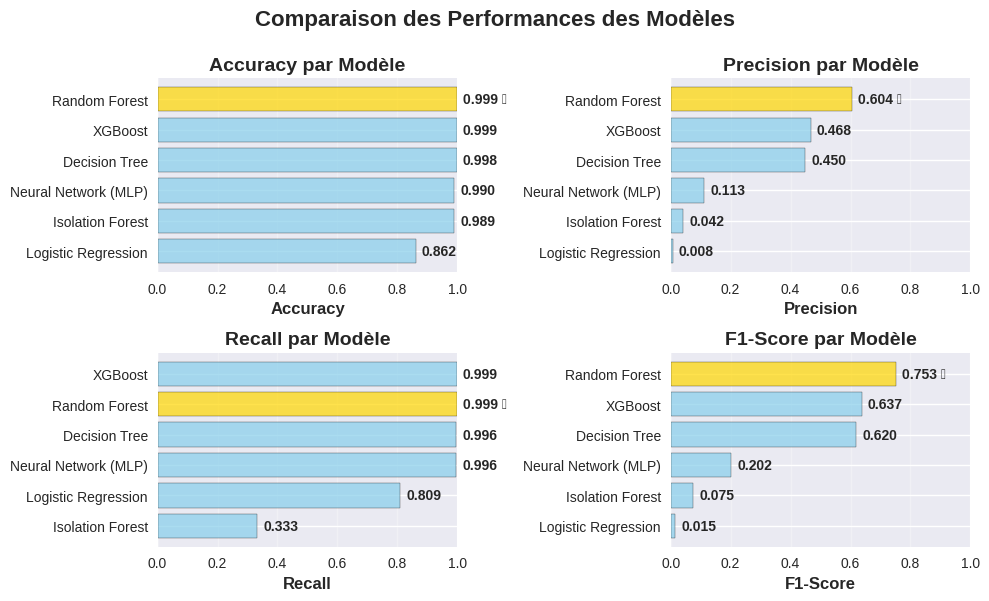

 Graphique sauvegardé: 06_model_comparison.png


<Figure size 1000x800 with 0 Axes>

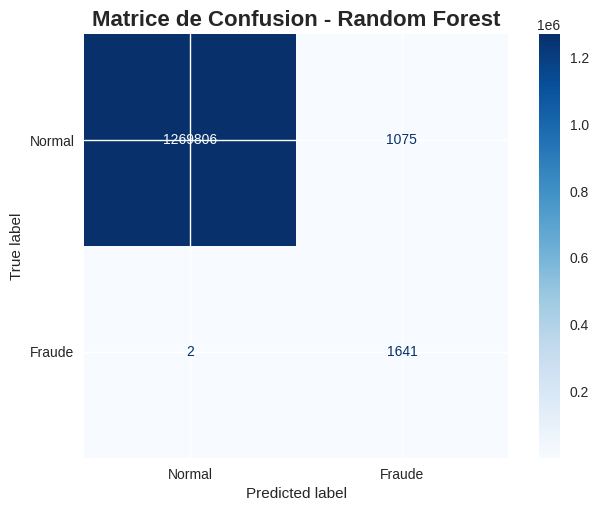

 Graphique sauvegardé: 07_confusion_matrix.png


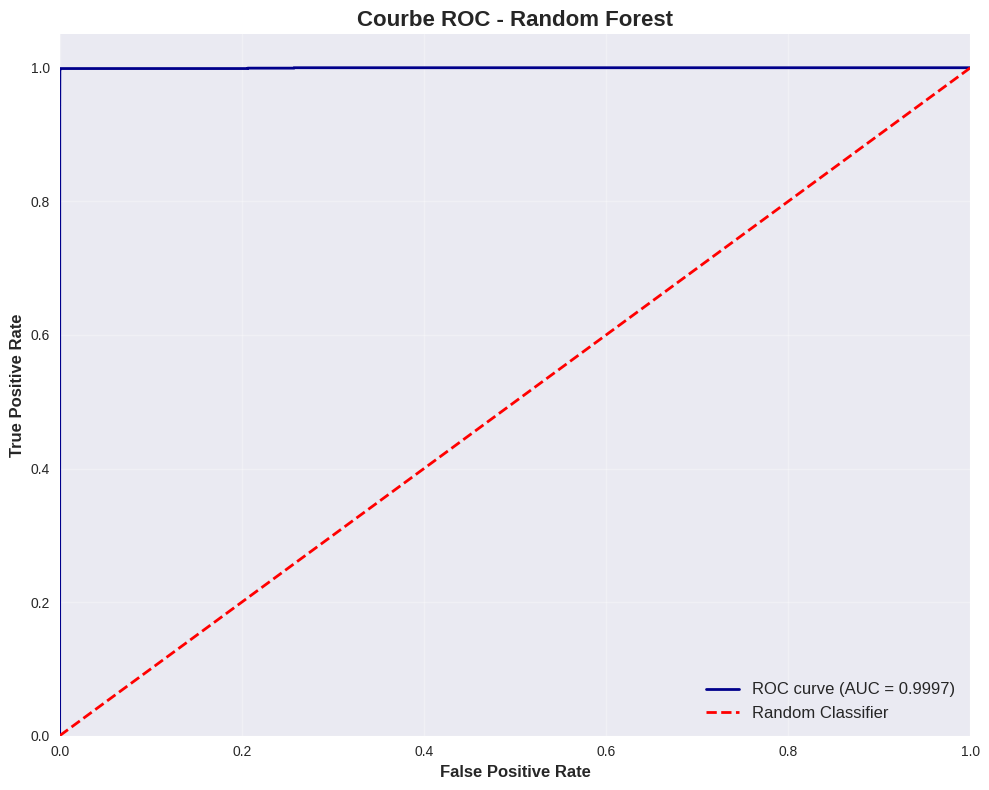

 Graphique sauvegardé: 08_roc_curve.png


In [9]:
# SECTION 9: VISUALISATIONS
# ============================================
print("\n" + "="*80)
print("GÉNÉRATION DES VISUALISATIONS")
print("="*80)

# Graphique 1: Comparaison des métriques
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    data = comparison_df.sort_values(metric, ascending=True)
    colors = ['gold' if m == best_model_name else 'skyblue' for m in data['Modèle']]
    bars = ax.barh(data['Modèle'], data[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} par Modèle', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, 1)

    for i, (v, model) in enumerate(zip(data[metric], data['Modèle'])):
        label = f'{v:.3f}'
        if model == best_model_name:
            label += ' 🏆'
        ax.text(v + 0.02, i, label, va='center', fontsize=10, fontweight='bold')

plt.suptitle('Comparaison des Performances des Modèles', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('06_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graphique sauvegardé: 06_model_comparison.png")

# Graphique 2: Matrice de confusion du meilleur modèle
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_model_info['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraude'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Matrice de Confusion - {best_model_name}', fontsize=16, fontweight='bold')
plt.savefig('07_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graphique sauvegardé: 07_confusion_matrix.png")

# Graphique 3: Courbe ROC
if best_model_info['predictions_proba'] is not None:
    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, best_model_info['predictions_proba'])
    auc = roc_auc_score(y_test, best_model_info['predictions_proba'])

    plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title(f'Courbe ROC - {best_model_name}', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('08_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(" Graphique sauvegardé: 08_roc_curve.png")

In [10]:
#SECTION 9.5: FEATURE ENGINEERING POUR PRODUCTION
def build_features(transaction_dict):
    """
    Construit automatiquement les features à partir d'une transaction brute
    """
    df = pd.DataFrame([transaction_dict])

    # Feature engineering (identique au training)
    df['amount_to_balance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
    df['dest_balance_ratio'] = df['amount'] / (df['oldbalanceDest'] + 1)
    df['high_amount'] = (df['amount'] > X['amount'].quantile(0.95)).astype(int)
    df['round_amount'] = (df['amount'] % 1000 == 0).astype(int)
    df['zero_balance_orig'] = (df['oldbalanceOrg'] == 0).astype(int)

    # Encodage du type
    df['type_encoded'] = le.transform(df['type'])

    # Supprimer colonnes inutiles
    df = df.drop(['type'], axis=1)

    # Respecter l’ordre EXACT du modèle
    df = df[X_train.columns]

    return df


In [11]:
# SECTION 10: FONCTION DE PRÉDICTION (VERSION IDS)
# ============================================

print("\n" + "="*80)
print("FONCTION DE PRÉDICTION POUR PRODUCTION (LOGIQUE IDS)")
print("="*80)

# Chargement UNIQUE des composants (simulation production)
MODEL = joblib.load('best_fraud_model.pkl')
SCALER = joblib.load('scaler.pkl')

THRESHOLD = 0.75  # seuil de détection (politique bancaire)

def predict_fraud(transaction_dict):
    """
    Prédit si une transaction est frauduleuse
    en utilisant un score de risque + seuil (IDS bancaire)
    """

    # 1️ Construction automatique des features
    df_features = build_features(transaction_dict)

    # 2️ Normalisation
    df_scaled = SCALER.transform(df_features)

    # 3️ Calcul du score de risque
    if hasattr(MODEL, 'predict_proba'):
        risk_score = MODEL.predict_proba(df_scaled)[0][1]
    else:
        risk_score = 0.9  # fallback sécurité

    # 4️ Décision basée sur le seuil
    is_fraud = risk_score >= THRESHOLD

    # 5️ Niveau de confiance (explicable)
    if risk_score >= 0.85:
        confidence = "TRÈS ÉLEVÉE"
    elif risk_score >= 0.7:
        confidence = "ÉLEVÉE"
    elif risk_score >= 0.5:
        confidence = "MOYENNE"
    else:
        confidence = "FAIBLE"

    return {
        "is_fraud": bool(is_fraud),
        "risk_score": float(risk_score),
        "confidence": confidence,
        "threshold_used": THRESHOLD,
        "model_used": best_model_name
    }



FONCTION DE PRÉDICTION POUR PRODUCTION (LOGIQUE IDS)


In [12]:
# SECTION 11: RAPPORT FINAL
# ============================================
print("\n" + "="*80)
print("RAPPORT FINAL DU PROJET")
print("="*80)

# Calculer des statistiques sur le meilleur modèle
cm = confusion_matrix(y_test, best_model_info['predictions'])
tn, fp, fn, tp = cm.ravel()

total_frauds = y_test.sum()
total_normal = len(y_test) - total_frauds

print(f"\n STATISTIQUES DU MEILLEUR MODÈLE ({best_model_name}):")
print("-" * 80)
print(f"Dataset Test: {len(y_test):,} transactions")
print(f"   • Transactions normales: {total_normal:,} ({total_normal/len(y_test)*100:.2f}%)")
print(f"   • Transactions frauduleuses: {total_frauds:,} ({total_frauds/len(y_test)*100:.2f}%)")

print(f"\nMatrice de Confusion:")
print(f"   • Vrais Négatifs (TN): {tn:,} - Transactions normales correctement identifiées")
print(f"   • Faux Positifs (FP): {fp:,} - Transactions normales marquées comme fraudes ")
print(f"   • Faux Négatifs (FN): {fn:,} - Fraudes manquées ")
print(f"   • Vrais Positifs (TP): {tp:,} - Fraudes correctement détectées ")

print(f"\nPerformances:")
print(f"   • Accuracy: {best_model_info['accuracy']:.2%} - Taux de prédictions correctes")
print(f"   • Precision: {best_model_info['precision']:.2%} - Fiabilité des alertes fraude")
print(f"   • Recall: {best_model_info['recall']:.2%} - Capacité à détecter les fraudes")
print(f"   • F1-Score: {best_model_info['f1_score']:.2%} - Score équilibré")
if 'auc_roc' in best_model_info:
    print(f"   • AUC-ROC: {best_model_info['auc_roc']:.2%} - Qualité globale du modèle")

print(f"\nImpact Business:")
print(f"   • Fraudes détectées: {tp}/{total_frauds} ({tp/total_frauds*100:.1f}%)")
print(f"   • Fraudes manquées: {fn}/{total_frauds} ({fn/total_frauds*100:.1f}%)")
print(f"   • Faux positifs (clients bloqués): {fp}/{total_normal} ({fp/total_normal*100:.2f}%)")

# Estimation financière (exemple avec montants moyens)
avg_fraud_amount = df[df['isFraud']==1]['amount'].mean()
estimated_loss_prevented = tp * avg_fraud_amount
estimated_loss_missed = fn * avg_fraud_amount

print(f"\n Estimation Financière (basée sur montants moyens):")
print(f"   • Montant moyen par fraude: {avg_fraud_amount:,.2f}€")
print(f"   • Pertes évitées (fraudes détectées): {estimated_loss_prevented:,.2f}€")
print(f"   • Pertes potentielles (fraudes manquées): {estimated_loss_missed:,.2f}€")
print(f"   • Taux de protection: {estimated_loss_prevented/(estimated_loss_prevented+estimated_loss_missed)*100:.1f}%")






RAPPORT FINAL DU PROJET

 STATISTIQUES DU MEILLEUR MODÈLE (Random Forest):
--------------------------------------------------------------------------------
Dataset Test: 1,272,524 transactions
   • Transactions normales: 1,270,881 (99.87%)
   • Transactions frauduleuses: 1,643 (0.13%)

Matrice de Confusion:
   • Vrais Négatifs (TN): 1,269,806 - Transactions normales correctement identifiées
   • Faux Positifs (FP): 1,075 - Transactions normales marquées comme fraudes 
   • Faux Négatifs (FN): 2 - Fraudes manquées 
   • Vrais Positifs (TP): 1,641 - Fraudes correctement détectées 

Performances:
   • Accuracy: 99.92% - Taux de prédictions correctes
   • Precision: 60.42% - Fiabilité des alertes fraude
   • Recall: 99.88% - Capacité à détecter les fraudes
   • F1-Score: 75.29% - Score équilibré
   • AUC-ROC: 99.97% - Qualité globale du modèle

Impact Business:
   • Fraudes détectées: 1641/1643 (99.9%)
   • Fraudes manquées: 2/1643 (0.1%)
   • Faux positifs (clients bloqués): 1075/1270881

In [13]:
# AFFICHER L'ORDRE DES COLONNES ATTENDU
print("\n Ordre des colonnes attendu par le modèle:")
print(X_train.columns.tolist())
# SECTION 12: TEST DE PRÉDICTION
print("\n" + "="*80)
print("TEST DE PRÉDICTION SUR UNE NOUVELLE TRANSACTION")
print("="*80)
# Test IDS – transaction suspecte
transaction_test = {
    "step": 1,
    "type": "TRANSFER",
    "amount": 20000,
    "oldbalanceOrg": 25000,
    "oldbalanceDest": 1000
}

print(predict_fraud(transaction_test))



 Ordre des colonnes attendu par le modèle:
['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'amount_to_balance_ratio', 'dest_balance_ratio', 'high_amount', 'round_amount', 'zero_balance_orig', 'type_encoded']

TEST DE PRÉDICTION SUR UNE NOUVELLE TRANSACTION
{'is_fraud': False, 'risk_score': 0.15572265122265122, 'confidence': 'FAIBLE', 'threshold_used': 0.75, 'model_used': 'Random Forest'}


In [14]:
# TÉLÉCHARGER LES FICHIERS DEPUIS COLAB
from google.colab import files
print("Téléchargement des fichiers...")
# Télécharger les modèles
files.download('best_fraud_model.pkl')
files.download('scaler.pkl')
# Si label_encoder existe
try:
    files.download('label_encoder.pkl')
except:
    print("label_encoder.pkl n'existe pas ")

print("Téléchargements terminés!")


Téléchargement des fichiers...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Téléchargements terminés!


In [19]:
# Cellule 1 : Configurer Git
!git config --global user.name "Nour-Selmi"
!git config --global user.email "nourselmi560@gmail.com"

In [20]:
# Cellule 2 : Cloner votre repository
!git clone https://github.com/votre-username/fraud-detection-system.git
%cd fraud-detection-system

Cloning into 'fraud-detection-system'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'fraud-detection-system'
/content
